In [274]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
import cv2

In [250]:
def Gabor(sigma, theta, f, psi, gamma):
    sigma_x = sigma
    sigma_y = sigma / gamma

    # Bounding box
    nstds = 3 # Number of standard deviation sigma
    xmax = 0.5
    xmin = -xmax
    
    ymax = 0.5
    ymin = -ymax
    
    n = 255
    
    stepx = np.abs(xmax - xmin)/n
    stepy = np.abs(ymax-ymin)/n
    
    (x, y) = np.meshgrid(np.arange(xmin, xmax, stepx), np.arange(ymin, ymax, stepy))

    # Rotation 
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * (np.cos(2 * np.pi * f * x_theta + psi) + 1j*np.sin(2 * np.pi * f * x_theta + psi))
    
    return gb
    

In [251]:
theta = 0
f = 3
gamma = 1
psi = 0
c =0.25
sigma = c/f

gb = Gabor(sigma, theta, f, psi, gamma) 

G0 = np.real(gb)
H0 = np.imag(gb)

G0F = np.fft.fftshift(np.fft.fft2(G0))
ampG0 = np.absolute(G0F)

H0F = np.fft.fft2(H0)
ampH0 = np.fft.fftshift(np.absolute(H0F))

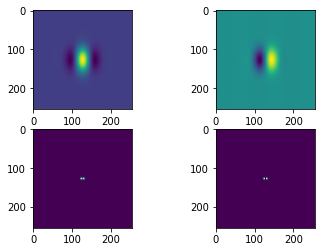

In [252]:
fig, axs = plt.subplots(2,2)



axs[0][0].imshow(G0)
axs[0][1].imshow(H0)

axs[1][0].imshow(ampG0)
axs[1][1].imshow(ampH0)

In [253]:
"""This function creats a 2D gaussian surface, we will be using this gaussian surfaces to creat the frame of our virtual video.""" 
def Gaussian(A, x0, y0, sigmax, sigmay, theta):
    imagelb = -5
    imageup = 5

    n_pixels = 255

    [X,Y] = np.meshgrid(np.linspace(imagelb,imageup,n_pixels),np.linspace(imagelb,imageup,n_pixels))

   

    a = cos(theta)**2/(2*sigmax**2) + sin(theta)**2/(2*sigmay**2)
    b = -sin(2*theta)/(4*sigmax**2) + sin(2*theta)/(4*sigmay**2)
    c = sin(theta)**2/(2*sigmax**2) + cos(theta)**2/(2*sigmay**2)


    Z = A*np.exp(-(a*np.power(X-x0,2) - 2*b*(X-x0)*(Y-y0) + c*np.power(Y-y0,2)))
    
    return Z

In [254]:
def generate_frame(motion1,motion2):
    
    x0 = 0
    y0 = 0
    sigmax = 1
    sigmay = 1
    theta = 0
    A1 = 1
    Z1 = Gaussian(A1, x0 + motion1, y0, sigmax, sigmay, theta)
    
    x0 = 0
    y0 = 0
    sigmax = 1
    sigmay = 1
    theta = 0
    A2 = 0
    Z2 = Gaussian(A2, x0 + motion2, y0, sigmax, sigmay, theta)

    Z = Z1 + Z2
    
    return Z

In [287]:
# First Frame , no motion is not applied
frame1 = generate_frame(0,0) 

frame2 = generate_frame(0.1, 0.1)

Text(0.5,1,'Frame 2')

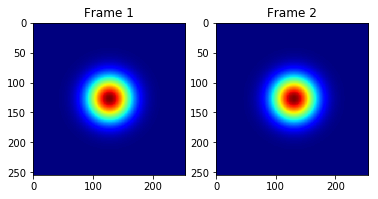

In [288]:
fig,axs = plt.subplots(1,2)

axs.ravel()
axs[0].imshow(frame1, cmap = 'jet')
axs[0].set_title("Frame 1")

axs[1].imshow(frame2, cmap = 'jet')
axs[1].set_title("Frame 2")

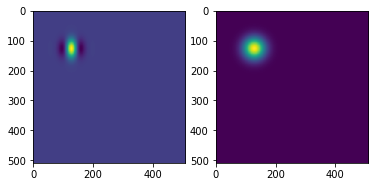

In [289]:
# Check if the recunstruction is working correct
Rows_Filt = G0.shape[0]
Cols_Filt = G0.shape[1]

Rows_img = frame1.shape[0]
Cols_img = frame1.shape[1]

N_Row = Rows_Filt + Rows_img -1
N_Col = Cols_Filt + Cols_img -1

frame1_pad = np.zeros((N_Row,N_Col))
frame1_pad[0:Rows_img,0:Cols_img] = frame1

G0_pad = np.zeros_like(frame1_pad)
G0_pad[0:Rows_Filt,0:Cols_Filt] = G0

fig, axs = plt.subplots(1,2)

axs.ravel()

axs[0].imshow(G0_pad)
axs[1].imshow(frame1_pad)


Text(0.5,1,'Recunstructed Frame')

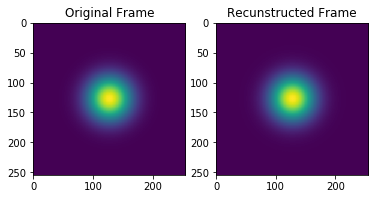

In [296]:
conv1 = fftconvolve(frame1, G0)

eps = 10**(-10)
recuns = np.fft.ifft2(np.fft.fft2(conv1)/(np.fft.fft2(G0_pad) + eps))
recuns = np.real(recuns[0:Rows_img,0:Cols_img])

recuns_error = abs(recuns - frame1)

fig, axs = plt.subplots(1,2)

axs.ravel()

axs[0].imshow(frame1)
axs[0].set_title('Original Frame')
axs[1].imshow(recuns)
axs[1].set_title('Recunstructed Frame')

In [291]:
def motion_magnify(frame1, frame2, Gabor,alpha):
    
    Rows_Filt = Gabor.shape[0]
    Cols_Filt = Gabor.shape[1]

    Rows_img = frame1.shape[0]
    Cols_img = frame1.shape[1]

    N_Row = Rows_Filt + Rows_img -1
    N_Col = Cols_Filt + Cols_img -1
    
    G0_pad = np.zeros((N_Row,N_Col))
    G0 = np.real(Gabor)
    G0_pad[0:Rows_Filt,0:Cols_Filt] = G0
    
    conv1 = fftconvolve(frame1, Gabor)
    conv2 = fftconvolve(frame2, Gabor)
    
    phi1 = np.angle(conv1)
    phi2 = np.angle(conv2)
    
    PHI = np.zeros((phi1.shape[0], phi1.shape[1],2))
    
    PHI[:,:,0] = phi1
    PHI[:,:,1] = phi2
    
    PHI = np.unwrap(PHI, axis=2)
    
    delta_phi = PHI[:,:,1] - PHI[:,:,0]
    
    magnified_phi = phi1 + alpha*delta_phi
    
    amp2 = np.absolute(conv2)
    
    x = amp2 * np.cos(magnified_phi)
    y = amp2 * np.sin(magnified_phi)
    
    magnified_complex = x + 1j*y
    
    eps = 0.00001
    
    magnified_img = np.fft.ifft2(np.fft.fft2(x)/(np.fft.fft2(G0_pad) + eps))
    magnified_img = np.real(magnified_img[0:Rows_img,0:Cols_img])
    
    
    return magnified_img

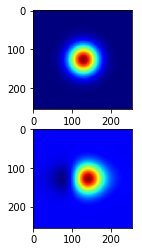

In [294]:
alpha = 10
magnified_frame = motion_magnify(frame1, frame2, gb,alpha)

fig, axs = plt.subplots(2,1)
axs.ravel()

axs[0].imshow(frame2, cmap = 'jet')
axs[1].imshow(magnified_frame, cmap = 'jet')